In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setting display parameters

pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# Setting dataset root path:
root_dataset = "datasets"

## Data Imports

In [2]:
cards_data = pd.read_csv(f"{root_dataset}/cards_data.csv").rename(columns={"id": "card_id"})
users_data = pd.read_csv(f"{root_dataset}/users_data.csv").rename(columns={"id": "client_id"})
transactions_data = pd.read_csv(f"{root_dataset}/transactions_data.csv").rename(columns={"id": "transaction_id"})
mcc_codes = pd.read_json(f"{root_dataset}/mcc_codes.json", typ='series').reset_index().rename(columns={"index": "mcc", 0: "mcc_description"})
train_fraud_labels = pd.read_json(f"{root_dataset}/train_fraud_labels.json").reset_index().rename(columns={"index": "transaction_id"})

## Data Preprocessing

### Card and Users Directory

In [3]:
users_data_columns = ["per_capita_income", "yearly_income", "total_debt"]

for col in users_data_columns:
    users_data[col] = users_data[col].str.replace("$", "").astype("float32")

cards_data["credit_limit"] = cards_data["credit_limit"].str.replace("$", "").astype("float32")

In [4]:
cards_users = pd.merge(users_data, cards_data, "inner", "client_id")

### MCC and Transactions Directory

In [5]:
transactions_data["amount"] = transactions_data["amount"].str.replace("$", "").astype("float32")

In [6]:
mcc_transactions = pd.merge(mcc_codes, transactions_data, "inner", "mcc")
mcc_transactions = pd.merge(mcc_transactions, train_fraud_labels, "inner", "transaction_id")

In [7]:
mcc_transactions.head()

,mcc,mcc_description,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,target
0,5812,Eating Places and Restaurants,7475390,2010-01-01 01:41:00,247,4155,3.290000,Swipe Transaction,92883,Lake Charles,LA,70605.0,NaN,No
1,5812,Eating Places and Restaurants,7475423,2010-01-01 02:14:00,474,2493,91.019997,Swipe Transaction,35451,Williston Park,NY,11596.0,NaN,No
2,5812,Eating Places and Restaurants,7475424,2010-01-01 02:15:00,1142,4674,3.680000,Swipe Transaction,59397,Cohasset,MA,2025.0,NaN,No
3,5812,Eating Places and Restaurants,7475434,2010-01-01 02:28:00,178,4261,57.430000,Swipe Transaction,78454,Grain Valley,MO,64029.0,NaN,No
4,5812,Eating Places and Restaurants,7475436,2010-01-01 02:32:00,1155,5784,27.629999,Swipe Transaction,1903,Miami,FL,33127.0,NaN,No


# Fraud Preprocessing

In [8]:
fraud_df = mcc_transactions[mcc_transactions["target"] == "Yes"].fillna("Unknown").sort_values("client_id")
not_fraud_df = mcc_transactions.drop(fraud_df.index, axis=0)

In [9]:
fraud_df["abs_amount_value"] = abs(fraud_df["amount"])
unique_card_id = fraud_df["card_id"].unique()
matching_indices = []

for card in unique_card_id:
    temp_df = fraud_df[fraud_df["card_id"] == card]
    grouped = temp_df.groupby("abs_amount_value")

    for val, group in grouped:
        if (group["amount"] > 0).any() and (group["amount"] < 0).any():
            # Add the indices of both + and - rows
            matching_indices.extend(group.index.tolist())



In [10]:
fraud_df = fraud_df.drop(matching_indices, axis=0)

In [11]:
not_fraud_df["abs_amount_value"] = abs(not_fraud_df["amount"])
unique_card_id = not_fraud_df["card_id"].unique()
matching_indices = []

for card in unique_card_id:
    temp_df = not_fraud_df[not_fraud_df["card_id"] == card]
    grouped = temp_df.groupby("abs_amount_value")

    for val, group in grouped:
        if (group["amount"] > 0).any() and (group["amount"] < 0).any():
            # Add the indices of both + and - rows
            matching_indices.extend(group.index.tolist())


In [12]:
not_fraud_df = not_fraud_df.drop(matching_indices, axis=0)

In [ ]:
fraud_df.to_csv("fraud_df.csv")
not_fraud_df.to_csv("not_fraud_df.csv")

# Analysis

In [13]:
analysis_fraud_df = fraud_df.merge(cards_users, 'inner', on="card_id").drop("client_id_y", axis=1).rename(columns={"client_id_x": "client_id"})
analysis_not_fraud_df = not_fraud_df.merge(cards_users, "inner", on="card_id").drop("client_id_y", axis=1).rename(columns={"client_id_x": "client_id"}).fillna("Unknown").drop("abs_amount_value", axis=1)

In [14]:
analysis_fraud_df.head(1)

,mcc,mcc_description,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,target,abs_amount_value,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,5300,Wholesale Clubs,16878036,2015-10-30 10:16:00,0,4639,5.13,Chip Transaction,85820,Falmouth,ME,4105.0,Unknown,Yes,5.13,33,69,1986,3,Male,858 Plum Avenue,43.59,-70.33,29237.0,59613.0,36199.0,763,4,Mastercard,Credit,5802759460691737,12/2019,312,YES,1,17600.0,09/2007,2014,No


In [15]:
analysis_not_fraud_df.head(1)

,mcc,mcc_description,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,5812,Eating Places and Restaurants,7475390,2010-01-01 01:41:00,247,4155,3.29,Swipe Transaction,92883,Lake Charles,LA,70605.0,Unknown,No,49,69,1970,7,Female,704 East Drive,30.21,-93.2,26772.0,54587.0,69070.0,761,6,Mastercard,Debit,5711629583407537,01/2012,577,YES,2,16751.0,08/2005,2010,No


### Card Type

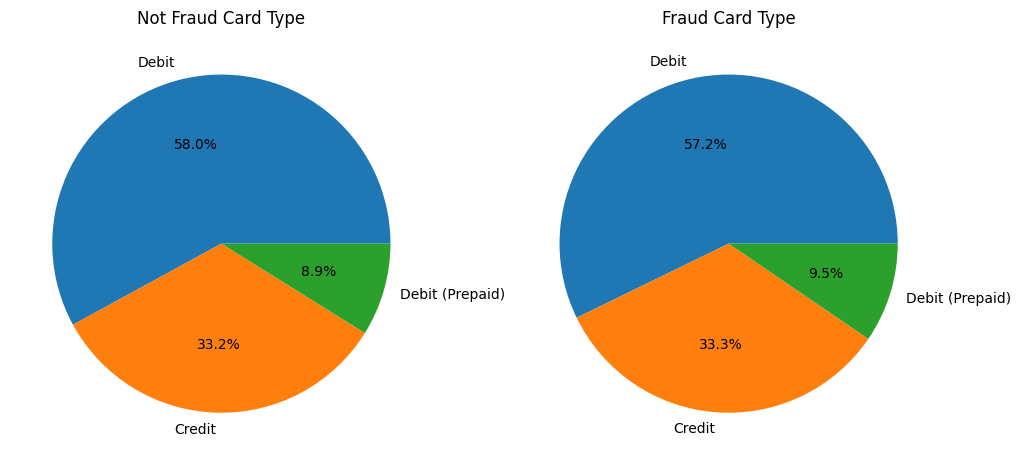

In [16]:
fraud_card_type_labels = analysis_fraud_df.drop_duplicates("card_id")["card_type"].value_counts().keys()
fraud_card_type_values = analysis_fraud_df.drop_duplicates("card_id")["card_type"].value_counts().values

not_fraud_card_type_labels = analysis_not_fraud_df.drop_duplicates("card_id")["card_type"].value_counts().keys()
not_fraud_card_type_values = analysis_not_fraud_df.drop_duplicates("card_id")["card_type"].value_counts().values

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figwidth(12)
fig.set_figheight(8)

ax1.pie(not_fraud_card_type_values, labels=not_fraud_card_type_labels, autopct='%.1f%%')
ax1.set_title("Not Fraud Card Type")

ax2.pie(fraud_card_type_values, labels=fraud_card_type_labels, autopct='%.1f%%')
ax2.set_title("Fraud Card Type")

plt.show()

### Card Brand

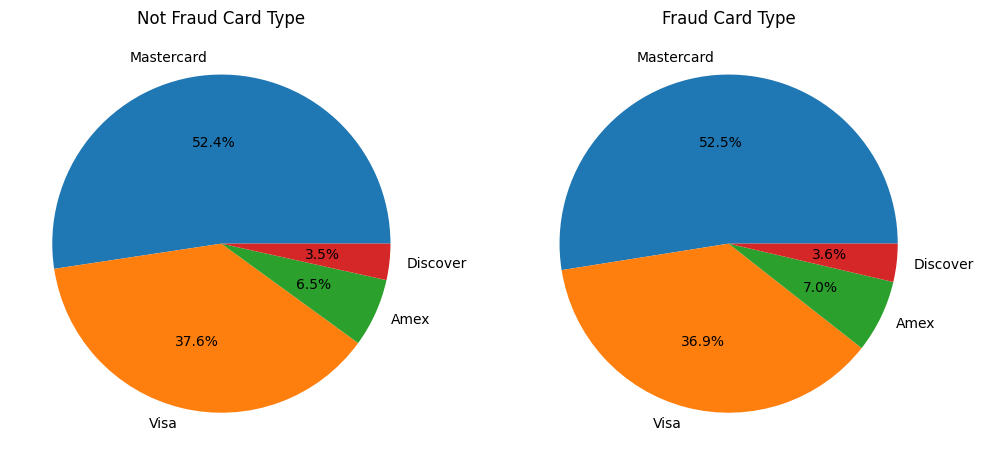

In [17]:
fraud_card_type_labels = analysis_fraud_df.drop_duplicates("card_id")["card_brand"].value_counts().keys()
fraud_card_type_values = analysis_fraud_df.drop_duplicates("card_id")["card_brand"].value_counts().values

not_fraud_card_type_labels = analysis_not_fraud_df.drop_duplicates("card_id")["card_brand"].value_counts().keys()
not_fraud_card_type_values = analysis_not_fraud_df.drop_duplicates("card_id")["card_brand"].value_counts().values

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figwidth(12)
fig.set_figheight(8)

ax1.pie(not_fraud_card_type_values, labels=not_fraud_card_type_labels, autopct='%.1f%%')
ax1.set_title("Not Fraud Card Type")

ax2.pie(fraud_card_type_values, labels=fraud_card_type_labels, autopct='%.1f%%')
ax2.set_title("Fraud Card Type")

plt.show()

### Chip Type

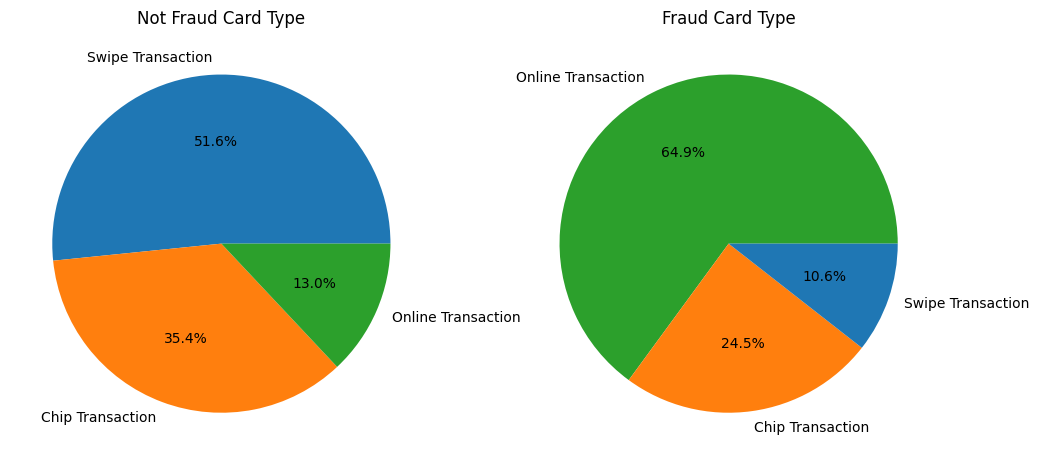

In [18]:
fraud_card_type_labels = analysis_fraud_df["use_chip"].value_counts().keys()
fraud_card_type_values = analysis_fraud_df["use_chip"].value_counts().values

not_fraud_card_type_labels = analysis_not_fraud_df["use_chip"].value_counts().keys()
not_fraud_card_type_values = analysis_not_fraud_df["use_chip"].value_counts().values

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figwidth(12)
fig.set_figheight(8)

ax1.pie(not_fraud_card_type_values, labels=not_fraud_card_type_labels, autopct='%.1f%%')
ax1.set_title("Not Fraud Card Type")

ax2.pie(fraud_card_type_values, labels=fraud_card_type_labels, autopct='%.1f%%', colors=["tab:green", "tab:orange", "tab:blue"])
ax2.set_title("Fraud Card Type")

plt.show()

### Description

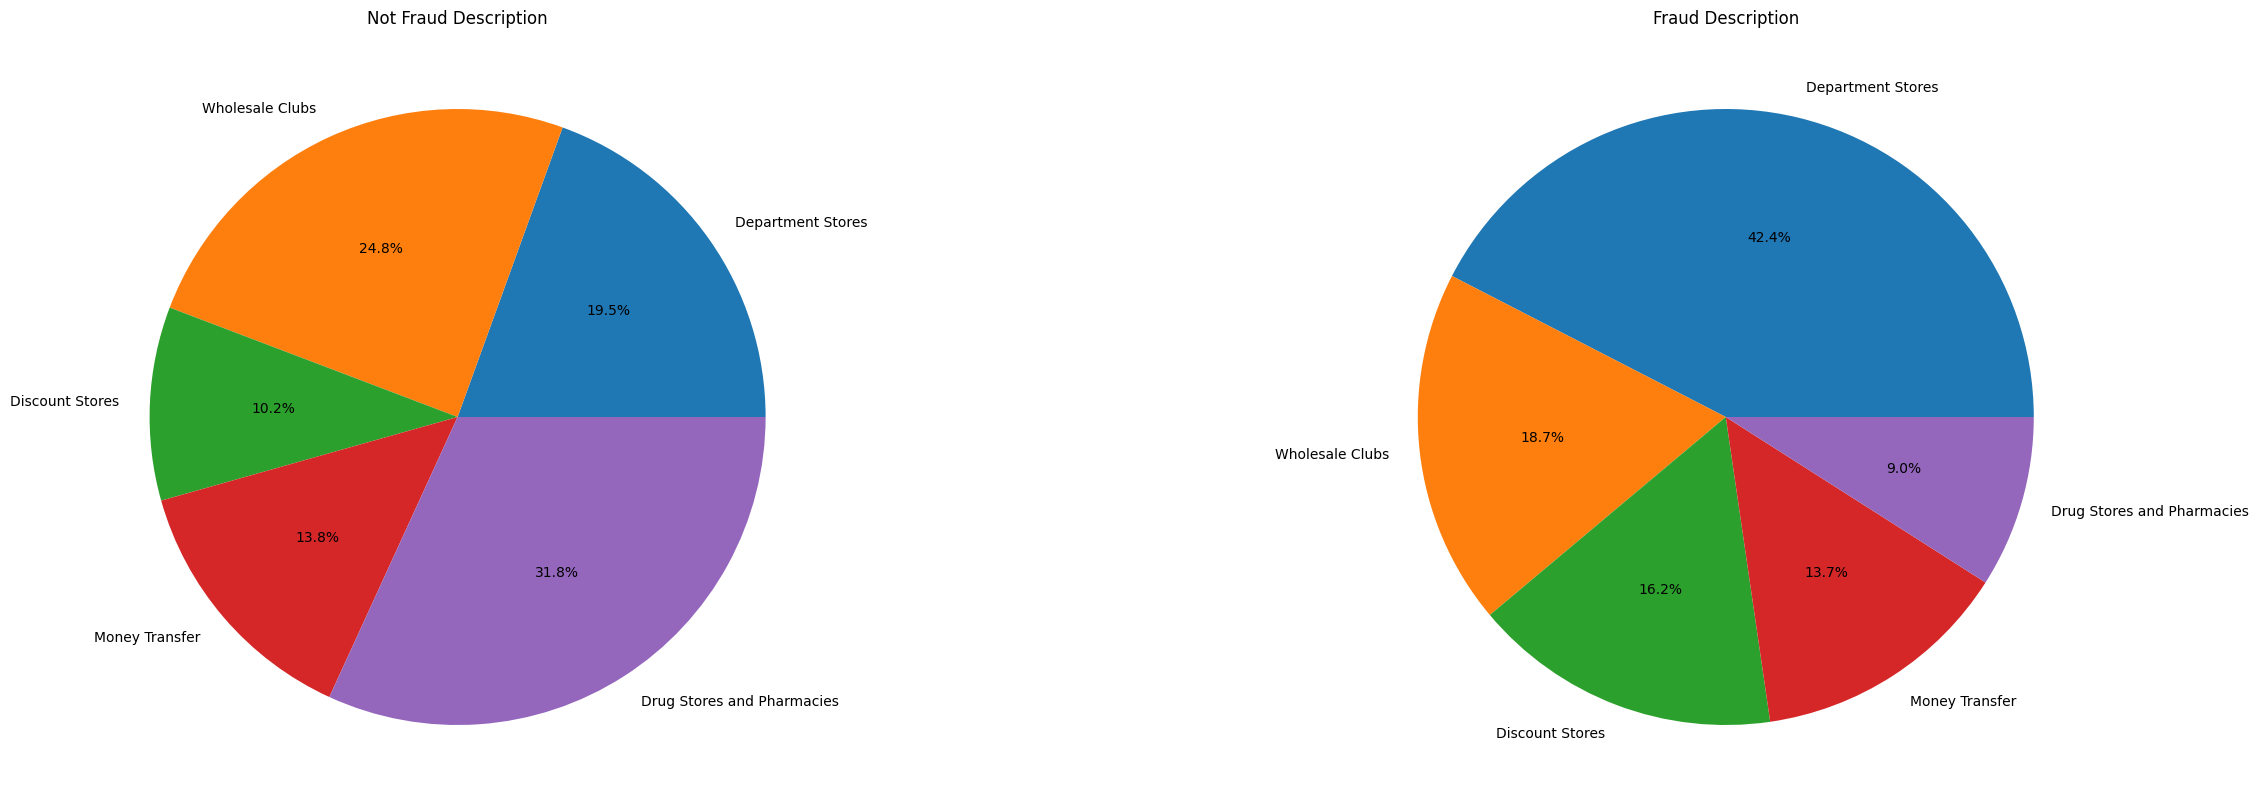

In [19]:
fraud_description = pd.DataFrame(analysis_fraud_df["mcc_description"].value_counts().sort_index().reset_index()).rename(columns={"count": "fraud_count"})
not_fraud_description = pd.DataFrame(analysis_not_fraud_df["mcc_description"].value_counts().sort_index().reset_index()).rename(columns={"count": "not_fraud_count"})

# Using OUTER JOIN to match both dataframes' descriptions and align them with their respective counts

description_comparison = pd.merge(fraud_description, not_fraud_description, "outer", "mcc_description").fillna("0")
description_comparison["fraud_count"] = description_comparison["fraud_count"].astype("float32")
description_comparison["not_fraud_count"] = description_comparison["not_fraud_count"].astype("float32")

top_5_descriptions = description_comparison.sort_values("fraud_count", ascending=False).reset_index(drop=True)[:5]

# Visualization

labels = top_5_descriptions["mcc_description"].values
fraud_description_values = top_5_descriptions["fraud_count"].values
not_fraud_description_values = top_5_descriptions["not_fraud_count"].values

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figwidth(30)
fig.set_figheight(10)

ax1.pie(not_fraud_description_values, labels=labels, autopct='%.1f%%')
ax1.set_title("Not Fraud Description")

ax2.pie(fraud_description_values, labels=labels, autopct='%.1f%%')
ax2.set_title("Fraud Description")

plt.show()

### Age Distribution for Each MCC

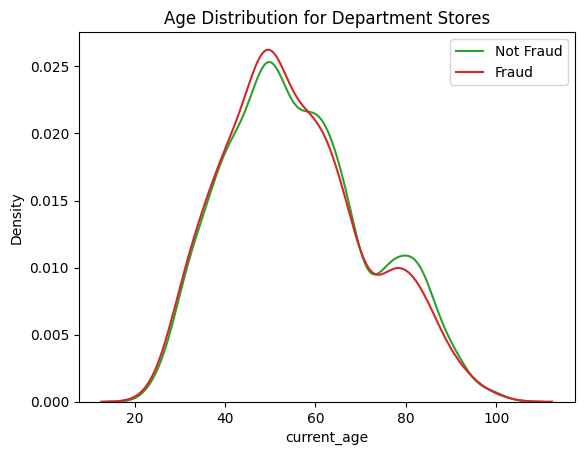

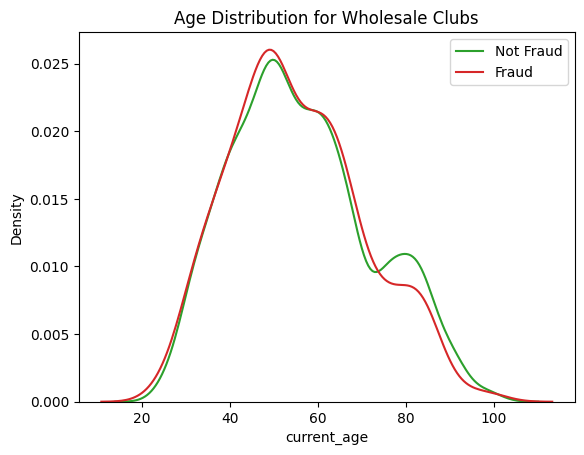

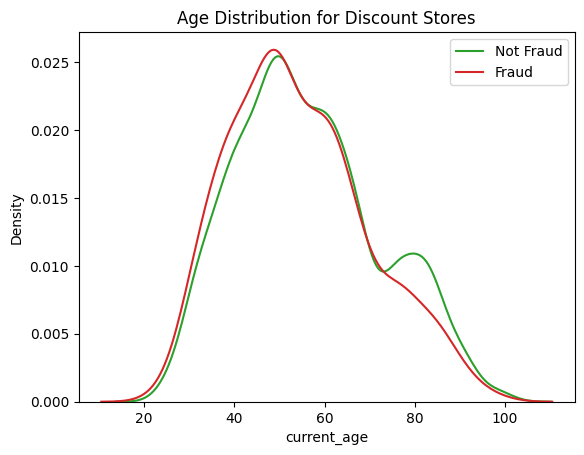

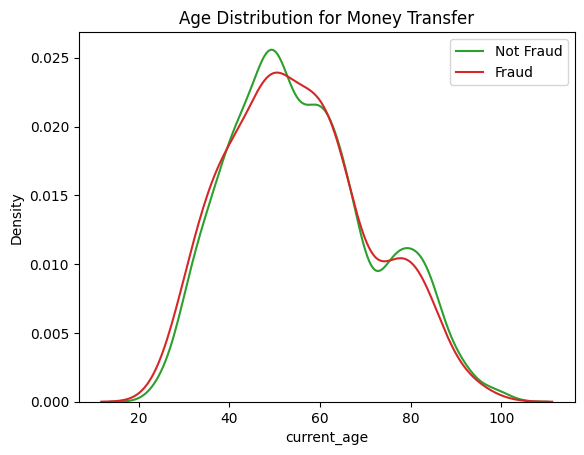

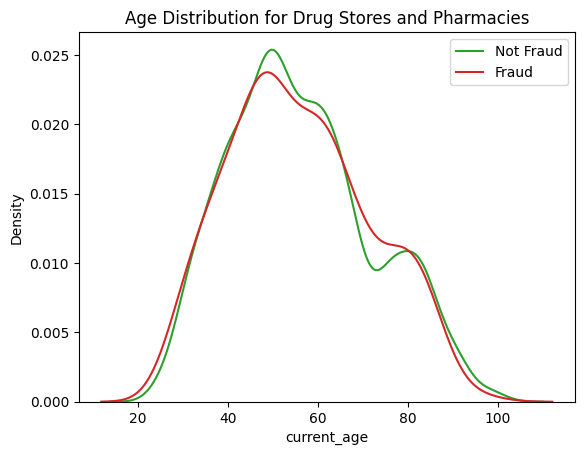

In [20]:
descs = top_5_descriptions["mcc_description"].to_list()

for desc in descs:
    temp_not_fraud_age = analysis_not_fraud_df[analysis_not_fraud_df["mcc_description"] == desc].drop_duplicates("card_id")
    temp_fraud_age = analysis_fraud_df[analysis_fraud_df["mcc_description"] == desc].drop_duplicates("card_id")

    plt.title(f"Age Distribution for {desc}")
    sns.kdeplot(temp_not_fraud_age, x="current_age", color="tab:green", label="Not Fraud")
    sns.kdeplot(temp_fraud_age, x="current_age", color="tab:red", label="Fraud")
    
    plt.legend()
    plt.show()

### Merchant Origin

In [21]:
analysis_fraud_df["merchant_city_state"] = analysis_fraud_df["merchant_city"] + ", " + analysis_fraud_df["merchant_state"]
analysis_not_fraud_df["merchant_city_state"] = analysis_not_fraud_df["merchant_city"] + ", " + analysis_not_fraud_df["merchant_state"]

In [22]:
analysis_not_fraud_df.head(1)

,mcc,mcc_description,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,merchant_city_state
0,5812,Eating Places and Restaurants,7475390,2010-01-01 01:41:00,247,4155,3.29,Swipe Transaction,92883,Lake Charles,LA,70605.0,Unknown,No,49,69,1970,7,Female,704 East Drive,30.21,-93.2,26772.0,54587.0,69070.0,761,6,Mastercard,Debit,5711629583407537,01/2012,577,YES,2,16751.0,08/2005,2010,No,"Lake Charles, LA"


In [23]:
analysis_fraud_df.head(1)

,mcc,mcc_description,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,errors,target,abs_amount_value,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,merchant_city_state
0,5300,Wholesale Clubs,16878036,2015-10-30 10:16:00,0,4639,5.13,Chip Transaction,85820,Falmouth,ME,4105.0,Unknown,Yes,5.13,33,69,1986,3,Male,858 Plum Avenue,43.59,-70.33,29237.0,59613.0,36199.0,763,4,Mastercard,Credit,5802759460691737,12/2019,312,YES,1,17600.0,09/2007,2014,No,"Falmouth, ME"


Text(0.5, 1.0, 'Fraud Merchant Cities')

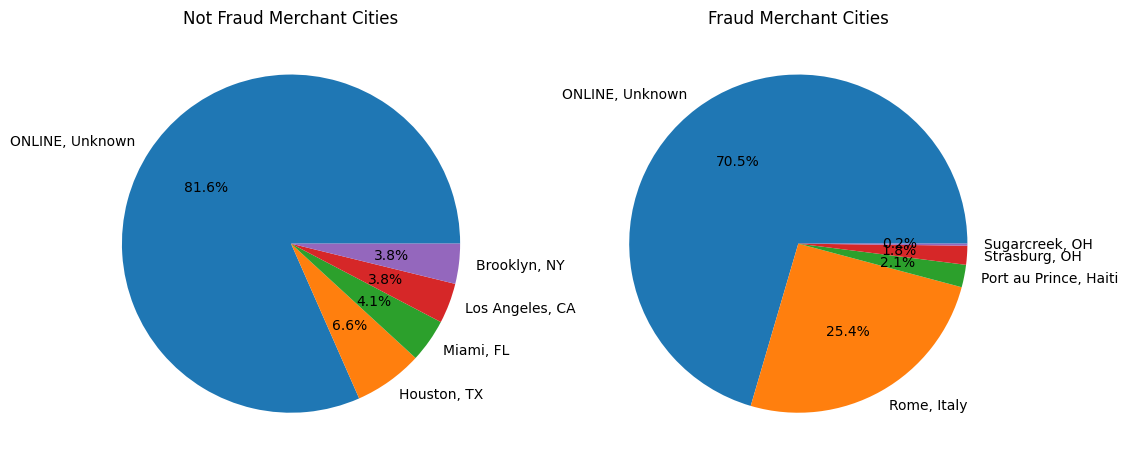

In [24]:
fraud_merchant_cities = analysis_fraud_df["merchant_city_state"].value_counts()[:5]
fraud_merchant_cities_labels = fraud_merchant_cities.keys()
fraud_merchant_cities_values = fraud_merchant_cities.values

not_fraud_merchant_cities = analysis_not_fraud_df["merchant_city_state"].value_counts()[:5]
not_fraud_merchant_cities_labels = not_fraud_merchant_cities.keys()
not_fraud_merchant_cities_values = not_fraud_merchant_cities.values


fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figwidth(12)
fig.set_figheight(8)

ax1.pie(not_fraud_merchant_cities_values, labels=not_fraud_merchant_cities_labels, autopct='%.1f%%')
ax1.set_title("Not Fraud Merchant Cities")

ax2.pie(fraud_merchant_cities_values, labels=fraud_merchant_cities_labels, autopct='%.1f%%')
ax2.set_title("Fraud Merchant Cities")

### Amount Spent

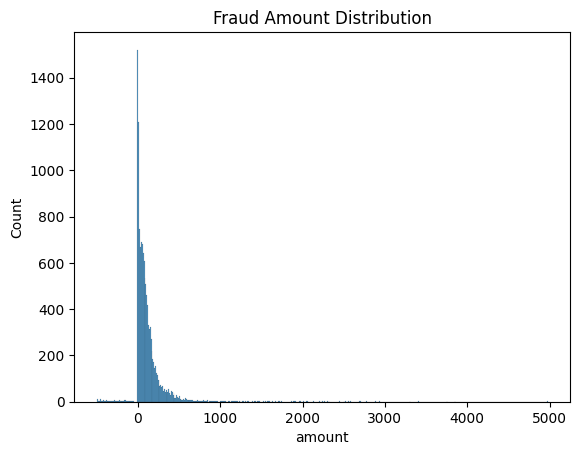

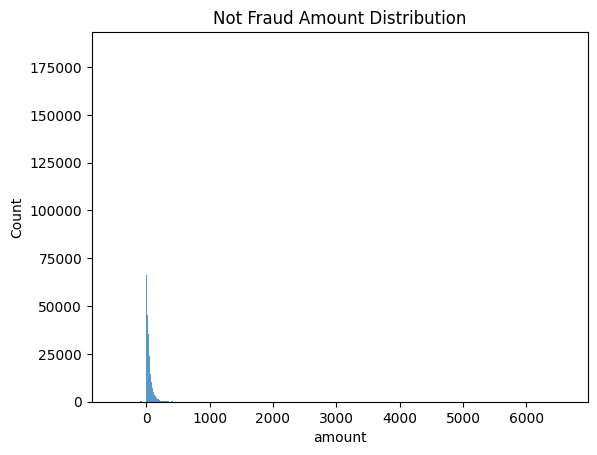

In [25]:
sns.histplot(analysis_fraud_df, x="amount")
plt.title("Fraud Amount Distribution")
plt.show()
sns.histplot(analysis_not_fraud_df, x="amount")
plt.title("Not Fraud Amount Distribution")
plt.show()

### Time that Transaction Happened

In [ ]:
analysis_fraud_df["date_day"] = pd.to_datetime(analysis_fraud_df["date"]).dt.day_name()
analysis_fraud_df["date_hour"] = pd.to_datetime(analysis_fraud_df["date"]).dt.hour
analysis_fraud_df["date_minute"] = pd.to_datetime(analysis_fraud_df["date"]).dt.minute

analysis_not_fraud_df["date_day"] = pd.to_datetime(analysis_not_fraud_df["date"]).dt.day_name()
analysis_not_fraud_df["date_hour"] = pd.to_datetime(analysis_not_fraud_df["date"]).dt.hour
analysis_not_fraud_df["date_minute"] = pd.to_datetime(analysis_not_fraud_df["date"]).dt.minute

In [ ]:
analysis_fraud_df["date_hour"] = analysis_fraud_df["date_hour"].astype("str")
analysis_not_fraud_df["date_hour"] = analysis_not_fraud_df["date_hour"].astype("str")


In [ ]:
analysis_fraud_df["date_day_hour"] = analysis_fraud_df["date_day"] + ", " + analysis_fraud_df["date_hour"]
analysis_not_fraud_df["date_day_hour"] = analysis_not_fraud_df["date_day"] + ", " + analysis_not_fraud_df["date_hour"]

### Card Has Chip or Not

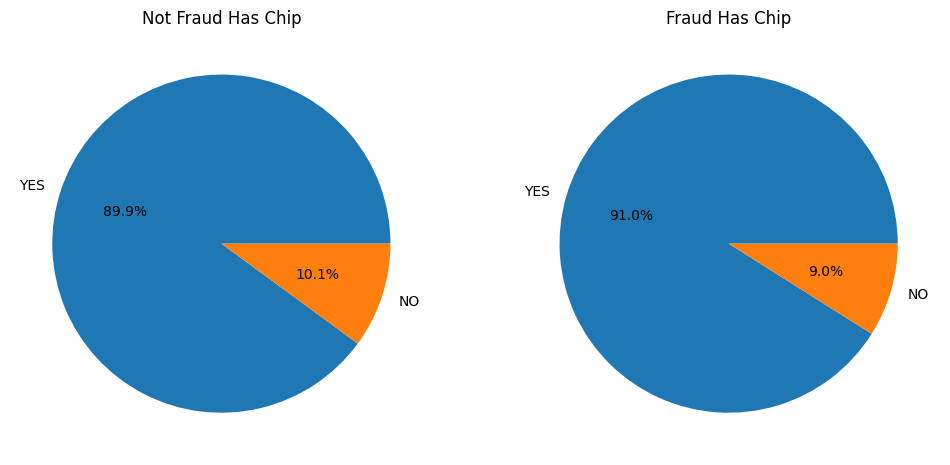

In [26]:
fraud_has_chip_labels = analysis_fraud_df["has_chip"].value_counts().keys()
fraud_has_chip_values = analysis_fraud_df["has_chip"].value_counts().values

not_fraud_has_chip_labels = analysis_not_fraud_df["has_chip"].value_counts().keys()
not_fraud_has_chip_values = analysis_not_fraud_df["has_chip"].value_counts().values

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figwidth(12)
fig.set_figheight(8)

ax1.pie(not_fraud_has_chip_values, labels=not_fraud_has_chip_labels, autopct='%.1f%%')
ax1.set_title("Not Fraud Has Chip")

ax2.pie(fraud_has_chip_values, labels=fraud_has_chip_labels, autopct='%.1f%%')
ax2.set_title("Fraud Has Chip")

plt.show()

In [27]:
unnecessary_columns = ['current_age','retirement_age','birth_year','birth_month','gender','zip','errors','acct_open_date','year_pin_last_changed','card_on_dark_web','cvv','expires','card_number','num_cards_issued', 'credit_limit', 'total_debt', 'latitude','longitude','per_capita_income','yearly_income','credit_score','num_credit_cards','card_brand', 'merchant_city', 'merchant_state', 'date', 'address', 'has_chip', 'mcc', 'client_id', 'card_id', 'merchant_id', 'card_type', 'transaction_id']

In [28]:
analysis_fraud_df = analysis_fraud_df.drop(unnecessary_columns, axis=1).drop("abs_amount_value", axis=1)

In [29]:
analysis_not_fraud_df = analysis_not_fraud_df.drop(unnecessary_columns, axis=1)

In [30]:
analysis_fraud_df.head(1)

,mcc_description,amount,use_chip,target,merchant_city_state
0,Wholesale Clubs,5.13,Chip Transaction,Yes,"Falmouth, ME"


In [32]:
analysis_not_fraud_df.head(1)

,mcc_description,amount,use_chip,target,merchant_city_state
0,Eating Places and Restaurants,3.29,Swipe Transaction,No,"Lake Charles, LA"


## Machine Learning Analysis

### Sampling

In [33]:
# Step 1: Set your stratification columns
stratify_cols = ['mcc_description', 'use_chip']

# Step 2: Size of the fraud dataset
target_sample_size = len(analysis_fraud_df)

# Step 3: Count group proportions in the NOT fraud dataset
grouped = analysis_not_fraud_df.groupby(stratify_cols).size().reset_index(name='count')
grouped['proportion'] = grouped['count'] / grouped['count'].sum()
grouped['sample_size'] = (grouped['proportion'] * target_sample_size).round().astype(int)

# Step 4: Merge back sample sizes into main dataset for fast filtering
analysis_not_fraud_df = analysis_not_fraud_df.merge(grouped, on=stratify_cols, how='inner')

# Step 5: Sample from each group efficiently
sampled_df = (
    analysis_not_fraud_df
    .groupby(stratify_cols)
    .apply(lambda x: x.sample(n=min(len(x), x['sample_size'].iloc[0]), random_state=42))
    .reset_index(drop=True)
)

# Step 6: If total sampled is less than required, top-up with random rows
n_needed = target_sample_size - len(sampled_df)

if n_needed > 0:
    # Drop sampled rows from original not-fraud df (to avoid duplicates)
    sampled_ids = sampled_df.index
    remaining = analysis_not_fraud_df.drop(index=sampled_ids, errors='ignore')

    # Sample the remaining rows
    filler = remaining.sample(n=n_needed, random_state=42)
    
    # Combine with the main sample
    sampled_df = pd.concat([sampled_df, filler], ignore_index=True)

# Confirm final row count
print(f"✅ Final sampled rows: {len(sampled_df)}")

sampled_analysis_not_fraud_df = sampled_df.drop(columns=['count', 'proportion', 'sample_size'])


/var/folders/9r/52_rs7314p3bv_fgylqjln500000gn/T/ipykernel_39973/1244552533.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), x['sample_size'].iloc[0]), random_state=42))


✅ Final sampled rows: 12679


In [34]:
sampled_analysis_not_fraud_df.head(1)

,mcc_description,amount,use_chip,target,merchant_city_state
0,"Accounting, Auditing, and Bookkeeping Services",212.970001,Chip Transaction,No,"Mobile, AL"


In [35]:
# Function to calculate and display value proportions
def show_proportions(df, cols, label):
    print(f"\n📊 Proportions in {label} dataset:")
    for col in cols:
        print(f"\n{col} proportions:")
        print(df[col].value_counts(normalize=True).sort_index())

# Original (full) not-fraud dataset proportions
show_proportions(analysis_not_fraud_df, stratify_cols, "original NOT fraud")

# Sampled not-fraud dataset proportions
show_proportions(sampled_analysis_not_fraud_df, stratify_cols, "sampled NOT fraud")



📊 Proportions in original NOT fraud dataset:

mcc_description proportions:
mcc_description
Accounting, Auditing, and Bookkeeping Services    0.000297
Airlines                                          0.000237
Amusement Parks, Carnivals, Circuses              0.000962
Antique Shops                                     0.000492
Artist Supply Stores, Craft Shops                 0.005709
                                                    ...   
Upholstery and Drapery Stores                     0.000237
Utilities - Electric, Gas, Water, Sanitary        0.020508
Welding Repair                                    0.000395
Wholesale Clubs                                   0.050803
Women's Ready-To-Wear Stores                      0.000871
Name: proportion, Length: 108, dtype: float64

use_chip proportions:
use_chip
Chip Transaction      0.353933
Online Transaction    0.129970
Swipe Transaction     0.516097
Name: proportion, dtype: float64

📊 Proportions in sampled NOT fraud dataset:

mcc_descr

In [36]:
combined_dataset = pd.concat([analysis_fraud_df, sampled_analysis_not_fraud_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

In [37]:
combined_dataset_copy = combined_dataset.copy()

In [38]:
combined_dataset_copy.head()

,mcc_description,amount,use_chip,target,merchant_city_state
0,Fast Food Restaurants,34.959999,Online Transaction,Yes,"ONLINE, Unknown"
1,Taxicabs and Limousines,15.160000,Online Transaction,No,"ONLINE, Unknown"
2,Discount Stores,71.410004,Chip Transaction,No,"New Bremen, OH"
3,Service Stations,59.730000,Chip Transaction,No,"Yorba Linda, CA"
4,Drug Stores and Pharmacies,148.169998,Chip Transaction,No,"Carlisle, PA"


In [39]:
dummy_use_chip_df = pd.get_dummies(combined_dataset_copy["use_chip"], drop_first=True, prefix="use_chip")
combined_dataset_copy = pd.concat([combined_dataset_copy, dummy_use_chip_df], axis=1).drop("use_chip", axis=1)

In [40]:
combined_dataset_copy["target"] = combined_dataset_copy["target"].apply(lambda x: 0 if x == "No" else 1)
combined_dataset_copy["use_chip_Online Transaction"] = combined_dataset_copy["use_chip_Online Transaction"].astype("int")
combined_dataset_copy["use_chip_Swipe Transaction"] = combined_dataset_copy["use_chip_Swipe Transaction"].astype("int")

In [41]:
target_mean = combined_dataset_copy.groupby("mcc_description")["target"].mean()
combined_dataset_copy["mcc_description"] = combined_dataset_copy["mcc_description"].map(target_mean)

In [42]:
target_mean_mcs = combined_dataset_copy.groupby("merchant_city_state")["target"].mean()
combined_dataset_copy["merchant_city_state"] = combined_dataset_copy["merchant_city_state"].map(target_mean_mcs)

In [43]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ["mcc_description", "amount", "merchant_city_state"]

scaler = MinMaxScaler()
combined_dataset_copy[columns_to_normalize] = scaler.fit_transform(combined_dataset_copy[columns_to_normalize])

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

X = combined_dataset_copy.drop("target", axis=1)
y = combined_dataset["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

logr = LogisticRegression()

logr.fit(X_train, y_train)

predictions = logr.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[3931  281]
 [ 124 4033]]
              precision    recall  f1-score   support

          No       0.97      0.93      0.95      4212
         Yes       0.93      0.97      0.95      4157

    accuracy                           0.95      8369
   macro avg       0.95      0.95      0.95      8369
weighted avg       0.95      0.95      0.95      8369

0.9516071215198949


In [49]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

predictions_dtc = dtc.predict(X_test)
print(confusion_matrix(y_test, predictions_dtc))
print(classification_report(y_test, predictions_dtc))
print(accuracy_score(y_test, predictions_dtc))

[[4019  193]
 [ 180 3977]]
              precision    recall  f1-score   support

          No       0.96      0.95      0.96      4212
         Yes       0.95      0.96      0.96      4157

    accuracy                           0.96      8369
   macro avg       0.96      0.96      0.96      8369
weighted avg       0.96      0.96      0.96      8369

0.9554307563627673


In [50]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

predictions_rfc = rfc.predict(X_test)

print(confusion_matrix(y_test, predictions_rfc))
print(classification_report(y_test, predictions_rfc))
print(accuracy_score(y_test, predictions_rfc))

[[4065  147]
 [ 167 3990]]
              precision    recall  f1-score   support

          No       0.96      0.97      0.96      4212
         Yes       0.96      0.96      0.96      4157

    accuracy                           0.96      8369
   macro avg       0.96      0.96      0.96      8369
weighted avg       0.96      0.96      0.96      8369

0.9624805831043135


<BarContainer object of 5 artists>

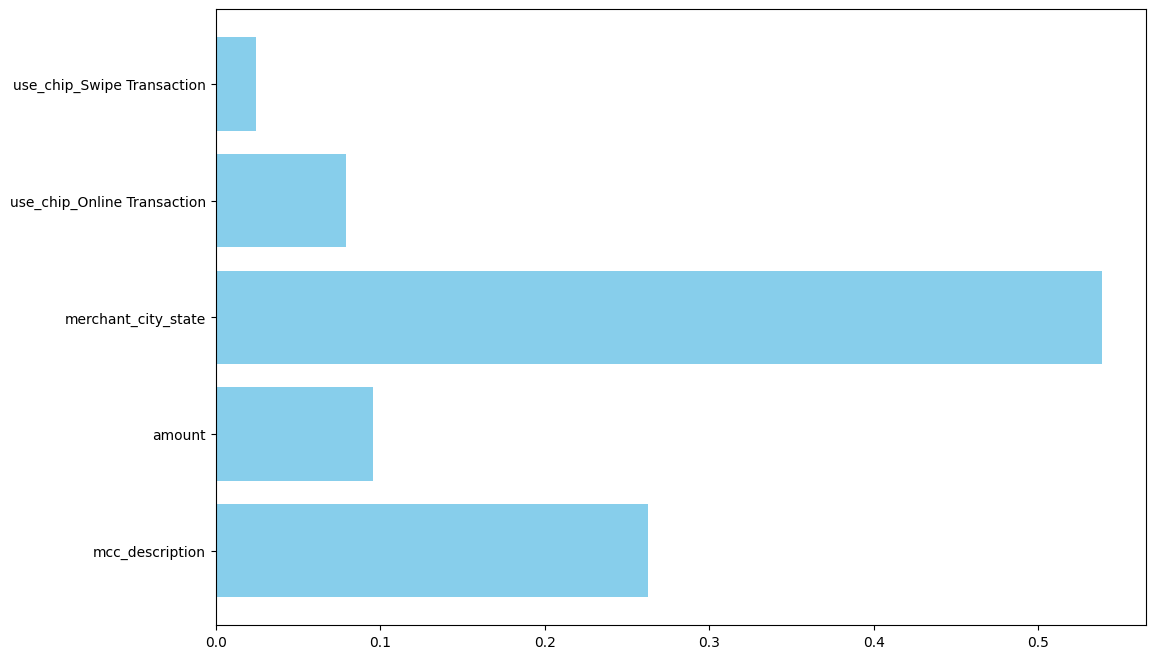

In [51]:
importances = rfc.feature_importances_
feature_imp_df = pd.DataFrame({"Features": X_train.columns, "importance": importances})

plt.figure(figsize=(12, 8))
plt.barh(X_train.columns, importances, color="skyblue")